***

# Social Network Analysis for Cyberbullying Detection

Made by: <br>
- Carreon, Ma. Addine Anne
- Chamorro, Hans Marvin
- Tabian, Luis Carlos
- Villapando, Christian James 

## Project Description

Cyberbullying has become a pressing concern due to the widespread use of social media platforms. With the anonymity provided by the internet, harmful interactions such as hate speech  discrimination, and harassment have risen. This project aims to use `Social Network Analysis (SNA)` to detect and analyze cyberbullying behaviors on Twitter. By constructing a network of interactions from the dataset, it can show connections between users, identify key influencer in cyberbullying, and detect clusters of harmful communication, using the Cyberbullying Classification dataset.

Objectives:
1. Construct a network where users (nodes) are connected based on mentions, replies, or retweets
in the dataset.
2. Identify key influencers in the spread of cyberbullying using centrality measures.
3. Identify groups of users who are frequently involved in cyberbullying incidents using clustering
techniques.
4. Combine Linguistic or Structural Network analysis with network properties to assess the
patterns of harmful interactions and identify toxic communities.

## Dataset Used
The Cyberbullying Classification dataset, sourced from the research paper "SOSNet: A Graph
Convolutional Network Approach to Fine-Grained Cyberbullying Detection" and available on
Kaggle, will serve as the primary data source. It contains over 47,000 tweets labeled into different
cyberbullying types:
- Age-based
- Ethnicity-based
- Gender-based
- Religion-based
- Other types
- Not cyberbullying
  
Key Features in the Dataset:
- tweet_text: The content of the tweet
- cyberbullying_type: The label indicating the type of cyberbullyingyberbullying

In [1]:
!pip install pyvis

### Python Libraries

In [2]:
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
from pyvis.network import Network
from itertools import combinations
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

from networkx.algorithms.centrality import (
    degree_centrality, 
    betweenness_centrality, 
    eigenvector_centrality
)

import community  # pip install python-louvain

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\villa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preparation and Exploratory Analysis

In [3]:
df = pd.read_csv(r"C:\Users\villa\Official-Folder\Data-Science\DS\DS195-1\Mini Project 2\Datasets\cyberbullying_tweets.csv")

In [4]:
df.columns.tolist()

['tweet_text', 'cyberbullying_type']

In [5]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [6]:
df['cyberbullying_type'].value_counts()

cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64

In [7]:
duplicate_count = df.duplicated().sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 36


In [8]:
if duplicate_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed!")
else:
    print("No duplicates found.")

Duplicates removed!


### Data Preprocessing for NLP 

In [9]:
# Download NLTK data if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define regex pattern for cleaning text
clean_pattern = r'@\S+|https?:\S+|http?:\S|[^A-Za-z\s]+'  # Keep only letters and spaces

# Load stopwords
stop_words = set(stopwords.words('english'))  # Use set for faster lookup

# Define additional words to remove (from observation)
extra_stopwords = {"rt", "amp", "mkr", "one", "get", "make", "think", "people", "like", "call"}
stop_words.update(extra_stopwords)

# Convert stop_words set to a list for CountVectorizer compatibility
stop_words_list = list(stop_words)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def text_preprocessing(text):
    text = re.sub(clean_pattern, ' ', text)  # Remove special characters and URLs
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords & lemmatize
    return " ".join(words)

# Apply preprocessing to dataset
df['tweet_text'] = df['tweet_text'].apply(text_preprocessing)

# Function to get top frequent words
def top_frequency_words(text, ng_range=(1,1), n=None):
    vector = CountVectorizer(ngram_range=ng_range, stop_words=stop_words_list)  # Ensure consistent stopwords
    bag_of_words = vector.fit_transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

# Function to filter tweets by cyberbullying type
def cyberbullying_type_data(cb_type, column_name='cyberbullying_type'):
    subset = df[df[column_name] == cb_type]
    return subset['tweet_text'].values

# Function to get most used words/phrases
def most_used_words_phrases(cb_data, n=10):
    unigrams = top_frequency_words(cb_data, (1,1), n)
    return pd.DataFrame(unigrams, columns=['Text', 'Count'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\villa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\villa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\villa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Visualization of Criterion Data

In [10]:
# Creating datasets of specific criterion of cyberbullying as obtained from the original dataset
gender_data = most_used_words_phrases(cyberbullying_type_data('gender'), 20)
religion_data = most_used_words_phrases(cyberbullying_type_data('religion'), 20)
ethnicity_data = most_used_words_phrases(cyberbullying_type_data('ethnicity'), 20)
age_data = most_used_words_phrases(cyberbullying_type_data('age'), 20)
other_cb_data = most_used_words_phrases(cyberbullying_type_data('other_cyberbullying'), 20)
not_cb_data = most_used_words_phrases(cyberbullying_type_data('not_cyberbullying'), 20)

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


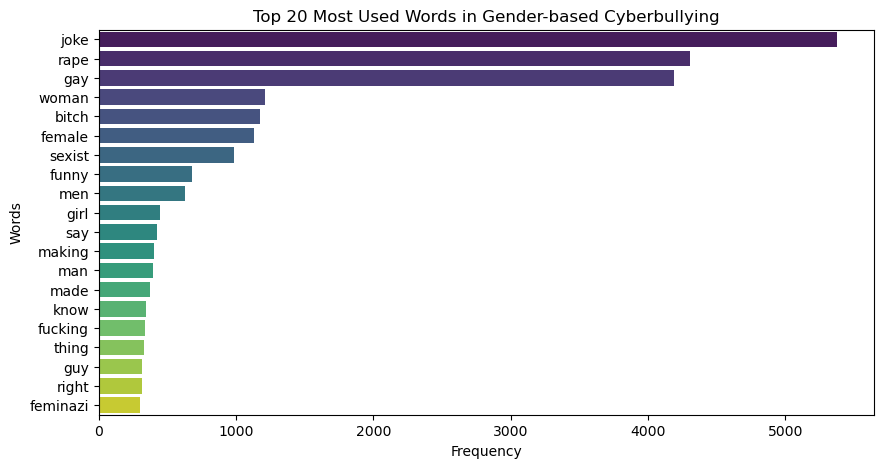

In [11]:
def plot_top_words(data, title):
    if 'Count' not in data.columns or 'Text' not in data.columns:
        print(f"Error: Expected columns 'Text' and 'Count' not found in {title} dataset")
        return
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top 20 Most Used Words in {title} Cyberbullying")
    plt.show()

# Visualize each dataset
plot_top_words(gender_data, "Gender-based")

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


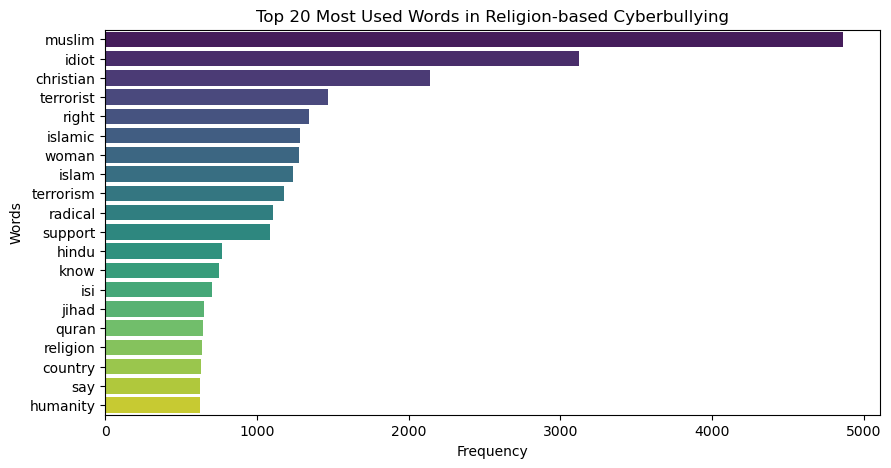

In [12]:
plot_top_words(religion_data, "Religion-based")

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


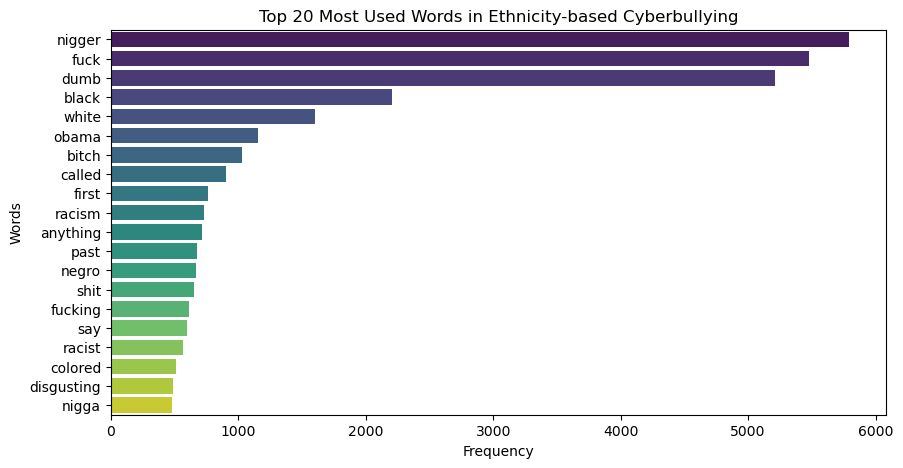

In [13]:
plot_top_words(ethnicity_data, "Ethnicity-based")

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


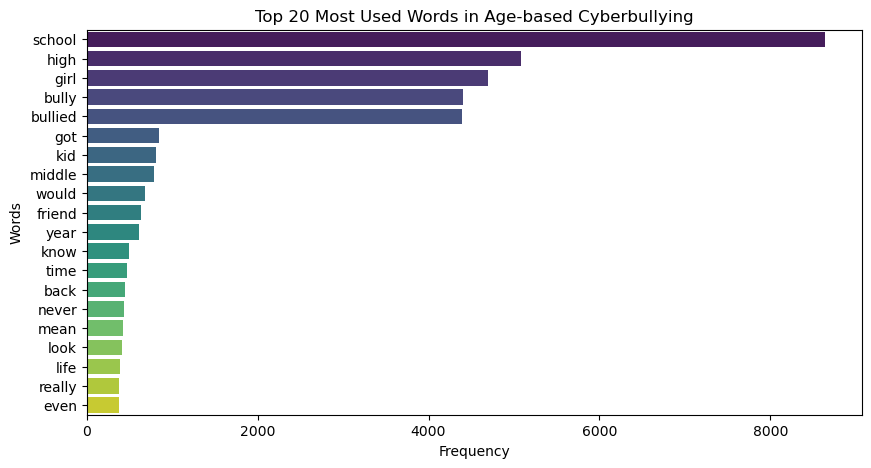

In [14]:
plot_top_words(age_data, "Age-based")

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


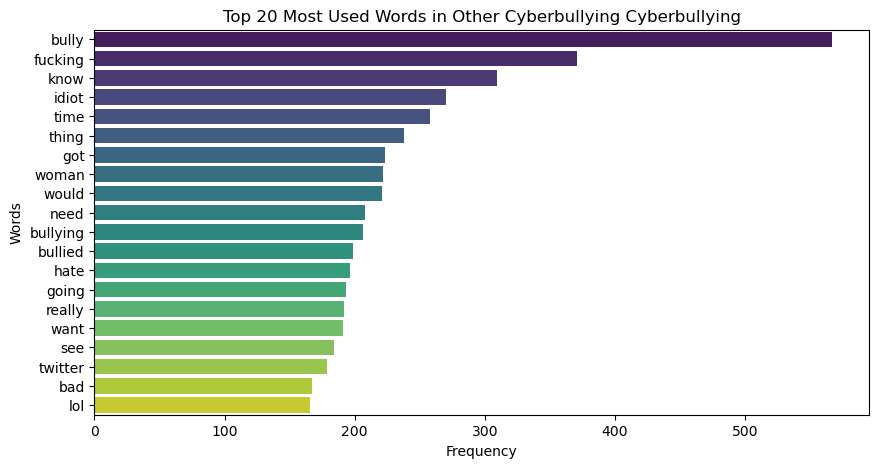

In [15]:
plot_top_words(other_cb_data, "Other Cyberbullying")

C:\Users\villa\AppData\Local\Temp\ipykernel_18020\1693969099.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data['Count'], y=data['Text'], palette='viridis')


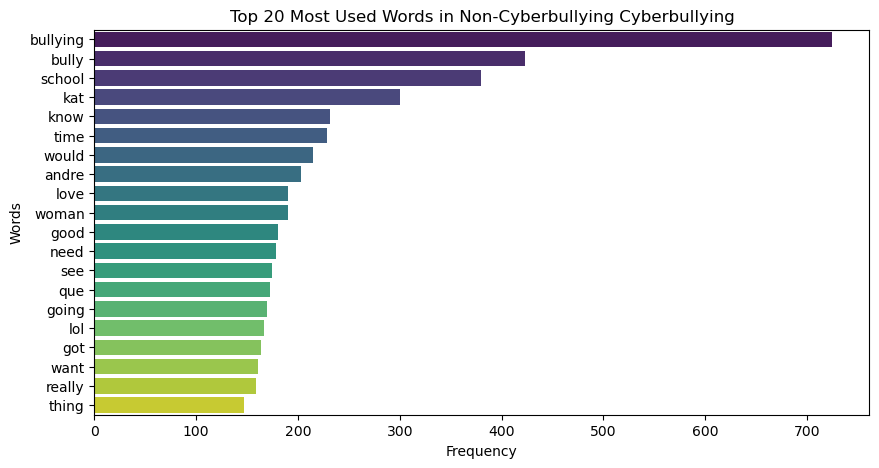

In [16]:
plot_top_words(not_cb_data, "Non-Cyberbullying")

### Visualization of Pre-processed Posts

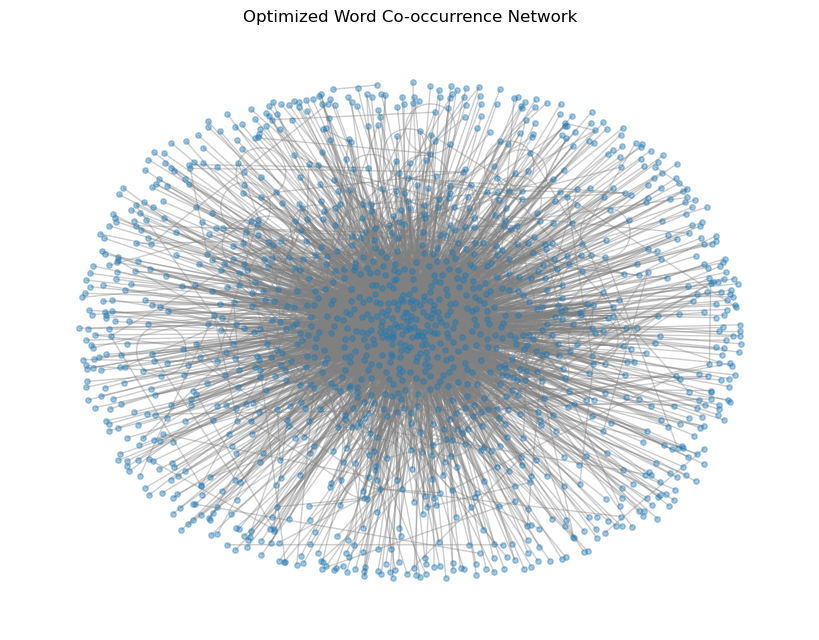

In [17]:
# Sample a subset of tweets (adjust percentage for speed vs accuracy)
df_sample = df.sample(frac=0.1, random_state=42)  # Use 10% of the dataset

# Tokenize and create word co-occurrence pairs
word_pairs = []
for words in df_sample['tweet_text'].apply(word_tokenize):
    filtered_words = [word.lower() for word in words if word.isalnum()]  # Remove punctuation
    for pair in combinations(filtered_words, 2):
        word_pairs.append(pair)

# Count occurrences and filter rare pairs
pair_counts = Counter(word_pairs)
filtered_pairs = {pair: count for pair, count in pair_counts.items() if count > 3}  # Keep frequent pairs

# Create graph with filtered edges
G = nx.Graph()
for (word1, word2), count in filtered_pairs.items():
    G.add_edge(word1, word2, weight=count)

# Draw a **smaller** network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, k=0.5)  # Optimize layout for speed
nx.draw(G, pos, node_size=15, edge_color='gray', alpha=0.4, with_labels=False)
plt.title("Optimized Word Co-occurrence Network")
plt.show()

In [18]:
deg_centrality = degree_centrality(G)
bet_centrality = betweenness_centrality(G)
eig_centrality = eigenvector_centrality(G, max_iter=1000)

# Sort and display top influential words
top_words = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top Words by Degree Centrality:", top_words)

Top Words by Degree Centrality: [('school', 0.37026447462473194), ('muslim', 0.26018584703359543), ('bullied', 0.24731951393852752), ('joke', 0.23445318084345962), ('girl', 0.21944245889921374), ('bully', 0.20729092208720515), ('high', 0.19156540385989992), ('idiot', 0.18227305218012868), ('gay', 0.15010721944245892), ('rape', 0.1472480343102216)]


In [19]:
from pyvis.network import Network
import networkx as nx
import community  # For detecting communities

# Detect communities
partition = community.best_partition(G)
nx.set_node_attributes(G, partition, 'community')

# Create a Pyvis network
net = Network(notebook=True, height="700px", width="100%", bgcolor="#222222", font_color="white")

# Define node positions
pos = nx.spring_layout(G)  

# Add nodes with community-based coloring
for node, community in partition.items():
    net.add_node(node, label=node, title=f"Word: {node}\nCommunity: {community}", color=plt.cm.viridis(community / max(partition.values())))

# Add edges
for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Enable physics for smoother interaction
net.toggle_physics(True)

# Save and display the graph
net.show("cyberbullying_network.html")

cyberbullying_network.html


### Tweet Clustering Based on Content

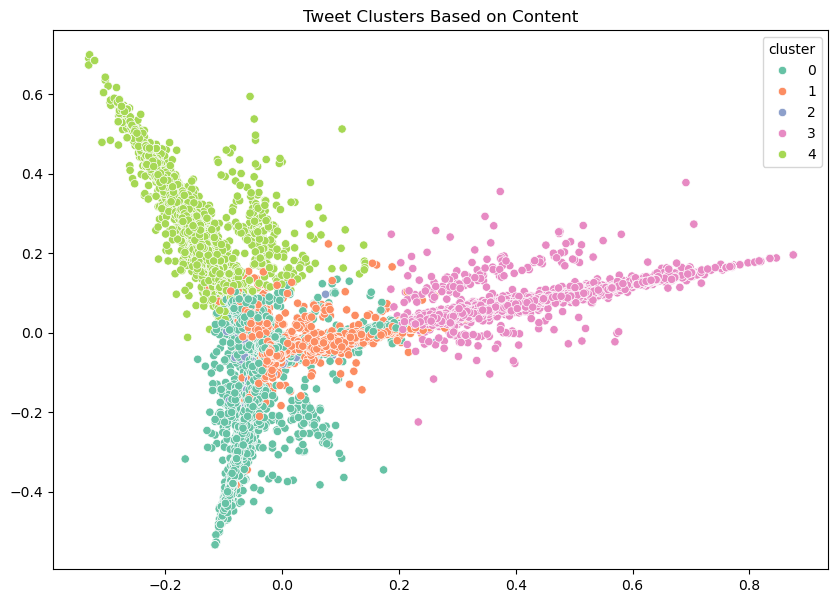

In [20]:
# Convert tweets to TF-IDF vectors
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df['tweet_text'])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette="Set2")
plt.title("Tweet Clusters Based on Content")
plt.show()

### User Clustering in Cyberbullying Incidents

In [21]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['tweet_text'])

In [22]:
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust clusters
df['cluster'] = kmeans.fit_predict(X)

In [23]:
top_words_per_cluster = []
for i in range(5):  # 5 clusters
    words = np.array(vectorizer.get_feature_names_out())[np.argsort(kmeans.cluster_centers_[i])[-10:]]
    top_words_per_cluster.append(words)

for i, words in enumerate(top_words_per_cluster):
    print(f"Cluster {i}: {', '.join(words)}")

Cluster 0: filled, filthy, year, islam, humanity, death, hatred, thousand, destruction, contributed
Cluster 1: year, friend, kid, got, middle, bullied, girl, high, bully, school
Cluster 2: black, christian, right, know, woman, idiot, muslim, gay, rape, joke
Cluster 3: stupid, shut, black, nigga, fucking, shit, bitch, nigger, dumb, fuck
Cluster 4: lol, president, hoe, bitch, mad, tayyoung, nigger, obama, dumb, fuck


In [24]:
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X.toarray())
df['dbscan_cluster'] = dbscan.labels_

### Toxic Community Identification Network Analysis

In [26]:
pip install python-louvain

In [27]:
# Compute community partition
import community.community_louvain as community
partition = community.best_partition(G)
df_words = pd.DataFrame(partition.items(), columns=['word', 'community'])

# Compute betweenness centrality
centrality = nx.betweenness_centrality(G)
df_centrality = pd.DataFrame(centrality.items(), columns=['word', 'centrality']).sort_values(by='centrality', ascending=False)

# Merge community and centrality data
df_analysis = df_words.merge(df_centrality, on='word')
df_analysis.sort_values(by='centrality', ascending=False).head(10)

# Create an interactive Pyvis network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

# Add nodes with labels and colors based on communities
for word, comm in partition.items():
    net.add_node(word, label=word, group=comm, title=f"Centrality: {centrality[word]:.4f}")

# Add edges
for edge in G.edges():
    net.add_edge(edge[0], edge[1])

# Show interactive network
net.show("cyberbullying_network.html")

cyberbullying_network.html


#### Projected Impact
a. Understanding Cyberbullying Patterns: Reveals how cyberbullying spreads in online
communities and identifies key influencers involved.<br>
b. Early Detection & Prevention: Helps detect harmful interactions early, allowing social
media platforms to take action before issues escalate.<br>
c. Provides insights for improving anti-bullying policies, moderation strategies, and
awareness campaigns.<br>
d. Supports ethical AI solutions that reduce harmful content and promote a healthier social media environment.<br>
e. Identification of Vulnerable Users: Pinpoints individuals or groups who are more likely to be targets of cyberbullying, enabling proactive support and intervention.<br>
f. User Empowerment: Equips users with tools and knowledge to identify, report, and
mitigate cyberbullying in their digital interactions.nteractions.

## References
Dataset file from: J. Wang, K. Fu, C.T. Lu, “SOSNet: A Graph Convolutional Network Approach to Fine-Grained Cyberbullying Detection,” Proceedings of the 2020 IEEE International Conference on Big Data (IEEE BigData 2020), December 10-13, 2020.

***